# 🏠 House Prices 이상값(outlier) 분석 실습 (문제용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 사용해
이상값(outlier)을 탐지하고 처리(drop/clip)하는 과정을 실습하기 위한 문제집입니다.

주요 목표
1. 이상값 후보 시각화(Boxplot, Scatter)
2. IQR 기반 이상값 경계 계산
3. 이상치 행 추출/분석
4. 이상치 처리 전략 (제거 vs 클리핑)
5. 처리 전/후 데이터 분포 비교 및 해석

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("../data/05_House Prices - Advanced Regression Techniques.csv")
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 핵심 수치형 변수 살펴보기
- 아래 변수들에 대해 describe()로 기본 통계를 확인하세요.
  - SalePrice (집값)
  - LotArea (대지 면적)
  - GrLivArea (지상 생활 면적)
  - GarageArea (차고 면적)
- 어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.

In [ ]:
# TODO: df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T

In [6]:
df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe()

,SalePrice,LotArea,GrLivArea,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,1515.463699,472.980137
std,79442.502883,9981.264932,525.480383,213.804841
min,34900.000000,1300.000000,334.000000,0.000000
25%,129975.000000,7553.500000,1129.500000,334.500000
50%,163000.000000,9478.500000,1464.000000,480.000000
75%,214000.000000,11601.500000,1776.750000,576.000000
max,755000.000000,215245.000000,5642.000000,1418.000000


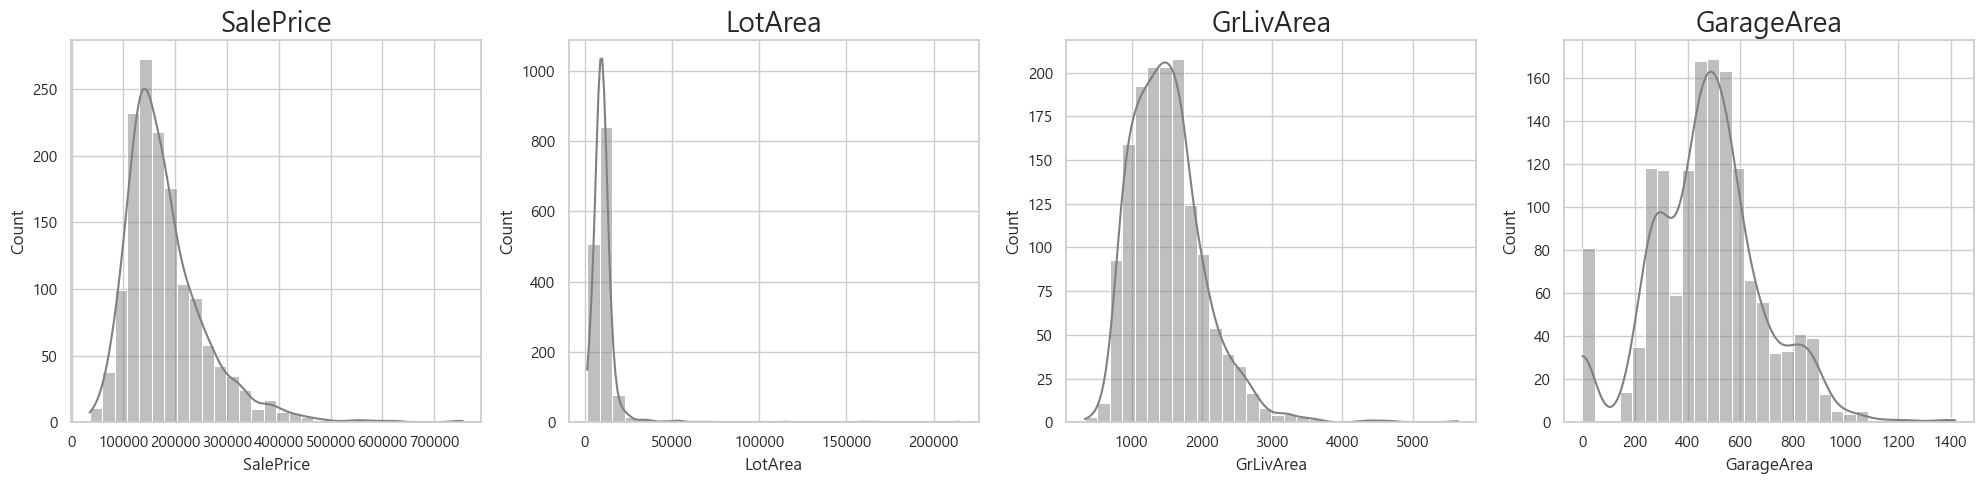

In [7]:
# 시각화할 컬럼들을 target_cols 리스트로 정의
target_cols = ['SalePrice','LotArea','GrLivArea','GarageArea']

# 변수 선언 | 1행 4열로 칸을 나눈다. | 전체 크기 설정
fig, axes = plt.subplots(1,4, figsize=(20, 5))

# enumerate를 통하여 순번(i) 컬럼명(col)과 반복 추출
for i, col in enumerate(target_cols):
    
    # bins: 구간 개수, kde: 밀도 곡선 표시, ax: 시각화되는 위치
    sns.histplot(df[col], bins=30, kde=True, color='gray', ax=axes[i])
    
    axes[i].set_title(col, fontsize=20)

# 레이아웃에 맞추도록 조정
plt.tight_layout()
plt.show()

* ===> SalePrice (집값)이 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포 처럼 보입니다.

## 문제 2️⃣: 박스플롯 & 산점도 시각화
1. `SalePrice`, `LotArea`, `GrLivArea`, `GarageArea` 각각 박스플롯(boxplot)으로 시각화하세요.
2. `GrLivArea` vs `SalePrice` 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

In [ ]:
# TODO:
# 1) 각 컬럼별 boxplot
# 2) GrLivArea vs SalePrice 산점도

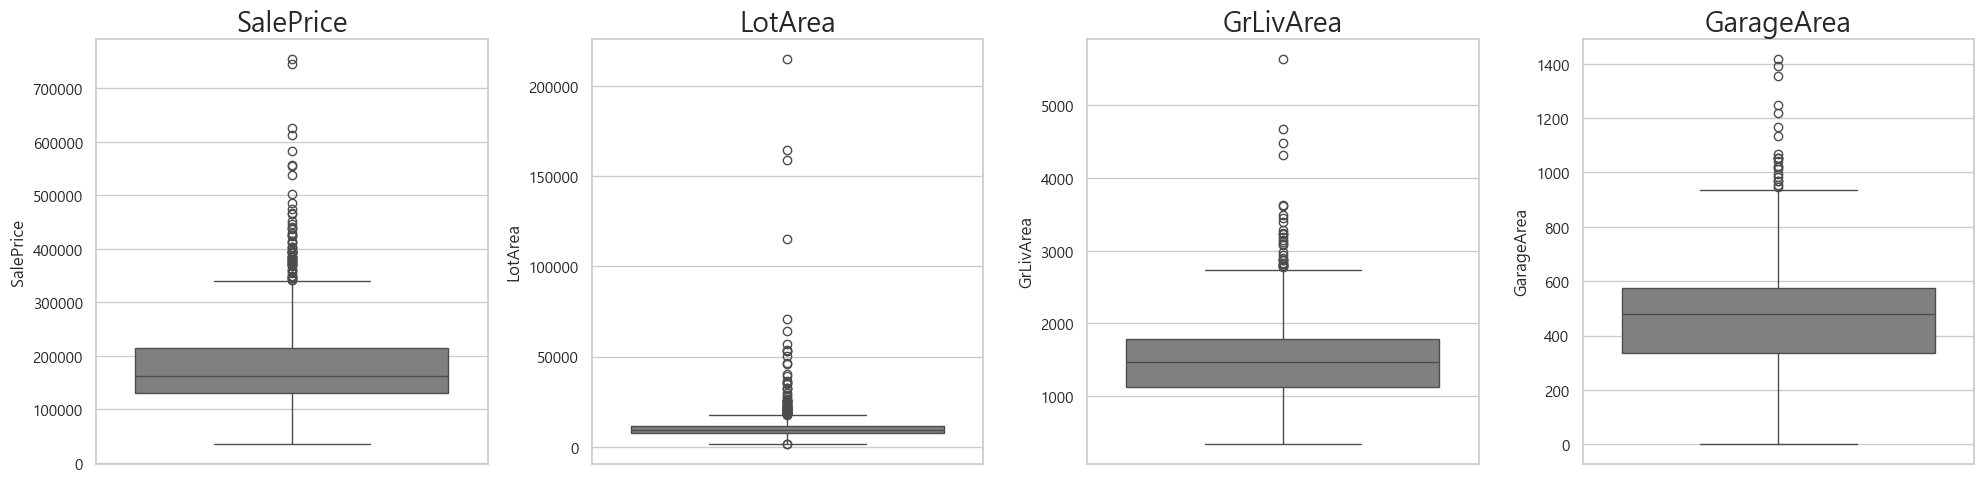

In [8]:
# (1)박스플롯(Boxplot) 시각화

# 시각화할 컬럼들을 target_cols 리스트로 정의
target_cols = ['SalePrice','LotArea','GrLivArea','GarageArea']

# 변수 선언 | 1행 4열로 칸을 나눈다. | 전체 크기 설정
fig, axes = plt.subplots(1,4, figsize=(20, 5))

# enumerate를 통하여 순번(i) 컬럼명(col)과 반복 추출
for i, col in enumerate(target_cols):
    sns.boxplot(y=df[col], color='gray', ax=axes[i])
    axes[i].set_title(col, fontsize=20)

# 레이아웃에 맞추도록 조정
plt.tight_layout()
plt.show()

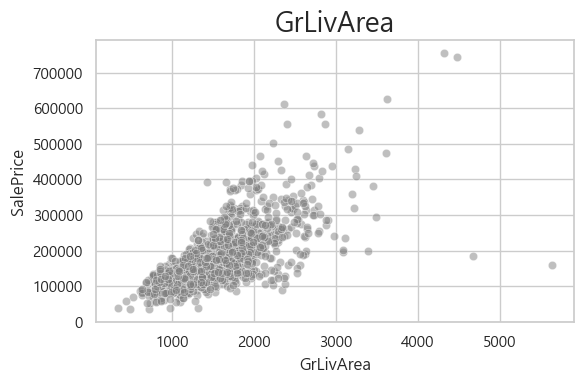

In [9]:
# (2)산점도 시각화 (GrLivArea vs SalePrice)

# 시각화할 컬럼들을 target_cols 리스트로 정의
target_cols = ['GrLivArea']

# 변수 선언 | 1행 4열로 칸을 나눈다. | 전체 크기 설정
fig, ax = plt.subplots(figsize=(6, 4))

# enumerate를 통하여 순번(i) 컬럼명(col)과 반복 추출
for col in target_cols:
    sns.scatterplot(data=df, x=col, y='SalePrice', color='gray', alpha=0.5, ax=ax)
    ax.set_title(col, fontsize=20)

# 레이아웃에 맞추도록 조정
plt.tight_layout()
plt.show()

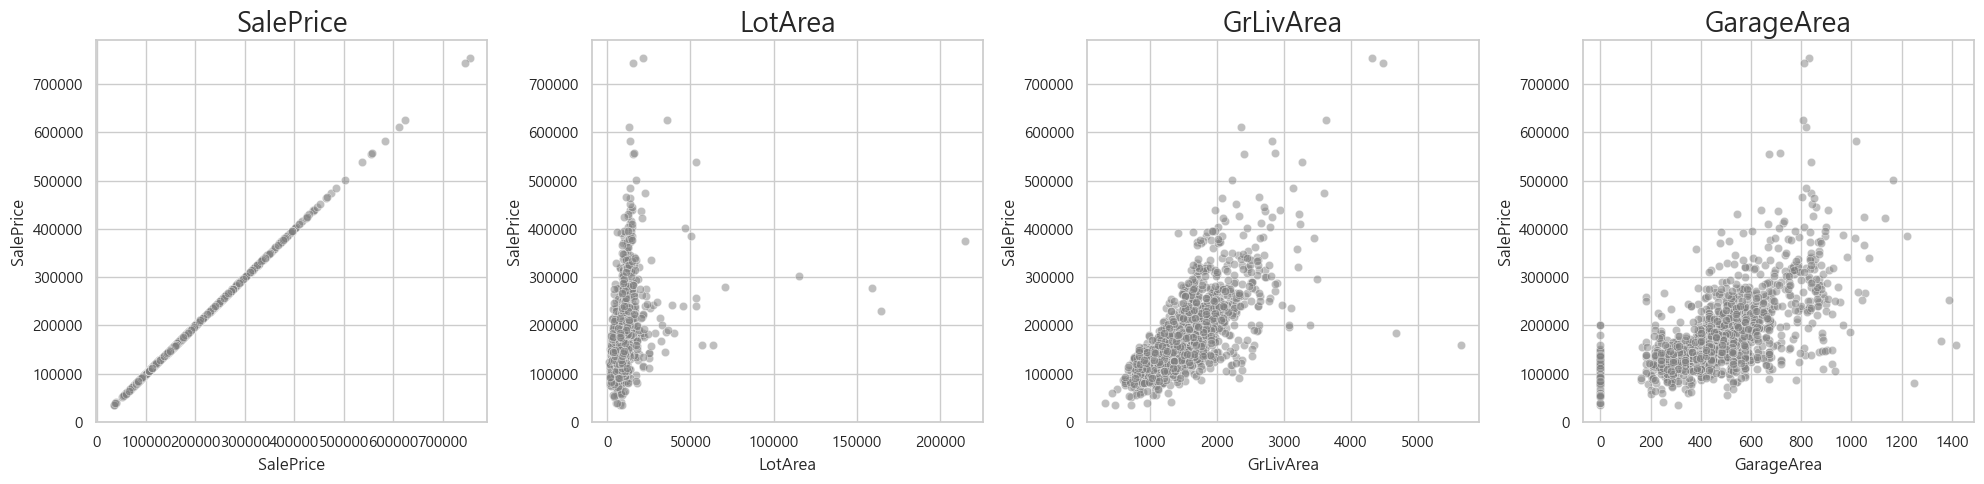

In [10]:
# (2)산점도 시각화 (target_cols vs SalePrice)

# 시각화할 컬럼들을 target_cols 리스트로 정의
target_cols = ['SalePrice','LotArea','GrLivArea','GarageArea']

# 변수 선언 | 1행 4열로 칸을 나눈다. | 전체 크기 설정
fig, axes = plt.subplots(1,4, figsize=(20, 5))

# enumerate를 통하여 순번(i) 컬럼명(col)과 반복 추출
for i, col in enumerate(target_cols):
    sns.scatterplot(data=df, x=col, y='SalePrice', color='gray', alpha=0.5, ax=axes[i])
    axes[i].set_title(col, fontsize=20)

# 레이아웃에 맞추도록 조정
plt.tight_layout()
plt.show()

## 문제 3️⃣: IQR 기반 이상값 경계 (SalePrice)
1. `SalePrice`의 Q1(25%), Q3(75%), IQR(Q3-Q1)을 구하세요.
2. IQR 방식으로 lower_bound, upper_bound를 계산하세요.
   - lower = Q1 - 1.5 * IQR
   - upper = Q3 + 1.5 * IQR
3. 이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하세요.

In [ ]:
# TODO:
# Q1,Q3,IQR 계산 후 IQR 기반 하한/상한, 이상치 개수와 비율 계산

In [ ]:
# (1)SalePrice의 Q1(25%), Q3(75%), IQR(Q3-Q1)

# ============================================
# Q1(25%): 129975.000000
# Q3(75%): 214000.000000
# QR(Q3-Q1): 184025.0

In [11]:
# (1-1)'describe()'를 사용하여 기초통계량 확인
df['SalePrice'].describe()

# ============================================
# Q1(25%): 129975.000000
# Q3(75%): 214000.000000

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [12]:
# (1-2)IQR 구하기
# QR(Q3-Q1)
# ============================================
IQR = 214000 - 129975
print('* IQR: ',IQR)

* IQR:  84025


In [13]:
# (2)IQR 방식으로 lower_bound, upper_bound를 계산

# lower_bound(하한선)
SalePrice_lower_bound = 129975 - (1.5 * 84025)

# upper_bound(상한선)
SalePrice_upper_bound = 214000 + (1.5 * 84025)

print('* lower_bound(하한선):', SalePrice_lower_bound, '|','* upper_bound(상한선):', SalePrice_upper_bound)

* lower_bound(하한선): 3937.5 | * upper_bound(상한선): 340037.5


In [14]:
# (3)이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하기

outliers = df[(df['SalePrice'] < SalePrice_lower_bound) | (df['SalePrice'] > SalePrice_upper_bound)]
outlier_count = len(outliers)
outlier_ratio = (outlier_count / len(df)) * 100

# ============================================
print(f"* 경계 범위: {SalePrice_lower_bound} ~ {SalePrice_upper_bound}")
print(f"* 이상값 개수: {outlier_count}")
print(f"* 전체 대비 비율: {outlier_ratio}")

* 경계 범위: 3937.5 ~ 340037.5
* 이상값 개수: 61
* 전체 대비 비율: 4.178082191780822


In [102]:
outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
11,12,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,345000
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
112,113,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,383970
151,152,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,1269,50,RL,NaN,14100,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,381000
1353,1354,50,RL,56.0,14720,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,410000
1373,1374,20,RL,NaN,11400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,466500
1388,1389,20,RL,42.0,14892,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,377500


## 문제 4️⃣: 면적 관련 이상값 탐지 (GrLivArea, LotArea)
GrLivArea와 LotArea 각각에 대해:
1. Q1, Q3, IQR 계산
2. lower_bound, upper_bound 계산
3. 경계를 벗어나는 데이터 개수 출력
4. GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고,
   '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.

In [ ]:
# TODO:
# GrLivArea, LotArea에 대해 IQR 이상치 개수 계산 후
# GrLivArea 이상치 샘플들의 GrLivArea, SalePrice, OverallQual, Neighborhood를 확인

In [52]:
##[(1)Q1, Q3, IQR 계산 ]#################################
# (1-1)GrLivArea의 Q1, Q3, IQR계산

# GrLivArea Q1
GrLivArea_q1 = df['GrLivArea'].describe()['25%']

# GrLivArea Q3
GrLivArea_q3 = df['GrLivArea'].describe()['75%']

# GrLivArea IQR
GrLivArea_iqr = GrLivArea_q3 - GrLivArea_q1


##[(2)lower_bound, upper_bound 계산 ]##################
GrLivArea_lower_bound = GrLivArea_q1 - (1.5 * GrLivArea_iqr)
GrLivArea_upper_bound = GrLivArea_q3 + (1.5 * GrLivArea_iqr)

##[(3)경계를 벗어나는 데이터 개수 출력 ]################
GrLivArea_outliers = df[(df['GrLivArea'] < GrLivArea_lower_bound) | (df['GrLivArea'] > GrLivArea_upper_bound)]
GrLivArea_outlier_count = len(GrLivArea_outliers)
GrLivArea_outlier_ratio = (GrLivArea_outlier_count / len(df)) * 100


##[출력]################################################
print('=','(1)','='*50)
print(f"* Q1: {GrLivArea_q1} | * Q3: {GrLivArea_q3} | * IRQ: {GrLivArea_iqr}\n")  

print('=','(2)','='*50)
print(F"* lower_bound: {GrLivArea_lower_bound} | * upper_bound: {GrLivArea_upper_bound}\n")

print('=','(3)','='*50)
print(f"* 이상값 개수: {GrLivArea_outlier_count} | * 전체 대비 비율: {GrLivArea_outlier_ratio}\n")

print('=','(4 - GrLivArea의 outliers)','='*50)
print(GrLivArea_outliers[['GrLivArea', 'SalePrice']].sort_values(by='SalePrice').head())

= (1) ==================================================
* Q1: 1129.5 | * Q3: 1776.75 | * IRQ: 647.25

= (2) ==================================================
* lower_bound: 158.625 | * upper_bound: 2747.625

= (3) ==================================================
* 이상값 개수: 31 | * 전체 대비 비율: 2.1232876712328768

= (4 - GrLivArea의 outliers) ==================================================
      GrLivArea  SalePrice
1298       5642     160000
523        4676     184750
1031       3082     197000
635        3395     200000
1173       3086     200500


In [53]:
##[(1)Q1, Q3, IQR 계산 ]#################################
# (1-2)LotArea의 Q1, Q3, IQR계산

# LotArea Q1
LotArea_q1 = df['LotArea'].describe()['25%']

# LotArea Q3
LotArea_q3 = df['LotArea'].describe()['75%']

# LotArea IQR
LotArea_iqr = LotArea_q3 - LotArea_q1


##[(2)lower_bound, upper_bound 계산 ]##################
LotArea_lower_bound = LotArea_q1 - (1.5 * LotArea_iqr)
LotArea_upper_bound = LotArea_q3 + (1.5 * LotArea_iqr)


##[(3)경계를 벗어나는 데이터 개수 출력 ]################
LotArea_outliers = df[(df['LotArea'] < LotArea_lower_bound) | (df['LotArea'] > LotArea_upper_bound)]
LotArea_outlier_count = len(LotArea_outliers)
LotArea_outlier_ratio = (LotArea_outlier_count / len(df)) * 100


##[출력]################################################
print('=','(1)','='*50)
print(f"* Q1: {LotArea_q1} | * Q3: {LotArea_q3} | * IRQ: {LotArea_iqr}\n")

print('=','(2)','='*50)
print(F"* lower_bound: {LotArea_lower_bound} | * upper_bound: {GrLivArea_upper_bound}\n")

print('=','(3)','='*50)
print(f"* 이상값 개수: {GrLivArea_outlier_count} | 전체 대비 비율: {GrLivArea_outlier_ratio}\n")

print('=','(4 - LotArea의 outliers)','='*50)
print(LotArea_outliers[['LotArea', 'SalePrice']].sort_values(by='SalePrice').head())

= (1) ==================================================
* Q1: 7553.5 | * Q3: 11601.5 | * IRQ: 4048.0

= (2) ==================================================
* lower_bound: 1481.5 | * upper_bound: 2747.625

= (3) ==================================================
* 이상값 개수: 31 | 전체 대비 비율: 2.1232876712328768

= (4 - LotArea의 outliers) ==================================================
      LotArea  SalePrice
1039     1477      80000
1061    18000      81000
1383    25339     112000
422     21750     113000
1048    21750     115000


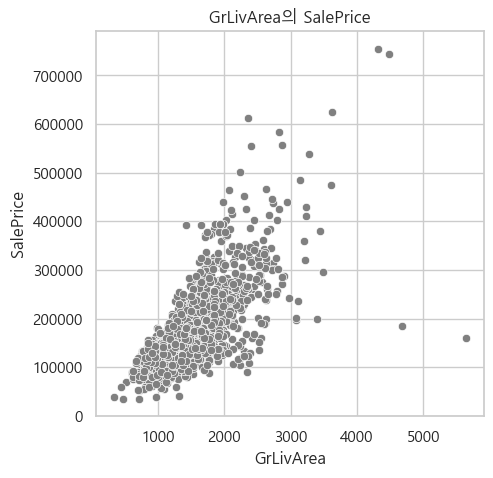

In [137]:
# GrLivArea의 SalePrice를 산점도(Scatter Plot)로 시각화
# => 이상치 확인

plt.figure(figsize=(5, 5))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], color='grey')
plt.title('GrLivArea의 SalePrice')
plt.show()

## 문제 5️⃣: 이상치 상세 살펴보기
위에서 찾은 GrLivArea 이상치들만 따로 df_outlier_area 데이터프레임으로 저장하고
해당 샘플들의 `GrLivArea`, `SalePrice`, `OverallQual`, `Neighborhood`를 출력하세요.
이 샘플들이 특정 동네에 몰려 있는지, 품질 점수(OverallQual)가 낮은데 크기만 큰 집은 있는지 서술하세요.

In [ ]:
# TODO:
# df_outlier_area를 만들고 주요 컬럼만 출력하여 특징을 관찰하세요.

In [54]:
##(1)이상치(upper_bound)들을 모아 df_outlier_area 이라는 데이터프레임으로 저장

df_outlier_area = df[(df['GrLivArea'] > GrLivArea_upper_bound)].copy()
df_outlier_area

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
118,119,60,RL,90.0,12376,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,320000
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
231,232,60,RL,174.0,15138,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,403000
304,305,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000
324,325,80,RL,96.0,11275,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,242000
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000


In [68]:
display_cols = ['GrLivArea', 'SalePrice', 'OverallQual', 'Neighborhood']
print(df_outlier_area[display_cols].sort_values(by='GrLivArea', ascending=False))

      GrLivArea  SalePrice  OverallQual Neighborhood
1298       5642     160000           10      Edwards
523        4676     184750           10      Edwards
1182       4476     745000           10      NoRidge
691        4316     755000           10      NoRidge
1169       3627     625000           10      NoRidge
185        3608     475000           10      OldTown
304        3493     295000            7      OldTown
1268       3447     381000            8      Crawfor
635        3395     200000            6        SWISU
769        3279     538000            8      StoneBr
1353       3238     410000            8      NoRidge
496        3228     430000            8      NoRidge
118        3222     320000            7      SawyerW
608        3194     359100            8      Crawfor
798        3140     485000            9      NridgHt
197        3112     235000            8        NAmes
1173       3086     200500            5      ClearCr
1031       3082     197000            7       

In [70]:
display_cols = ['GrLivArea', 'SalePrice', 'OverallQual', 'Neighborhood']
print(df_outlier_area[display_cols].sort_values(by='SalePrice', ascending=True))

      GrLivArea  SalePrice  OverallQual Neighborhood
1298       5642     160000           10      Edwards
523        4676     184750           10      Edwards
1031       3082     197000            7        SWISU
635        3395     200000            6        SWISU
1173       3086     200500            5      ClearCr
197        3112     235000            8        NAmes
324        2978     242000            7        NAmes
1386       2784     250000            7       NWAmes
1328       2792     256000            6      OldTown
961        2872     272000            6       NWAmes
1175       2872     285000            8      NoRidge
1024       2898     287000            8       Timber
304        3493     295000            7      OldTown
1312       2810     302000            8      NoRidge
118        3222     320000            7      SawyerW
583        2775     325000           10      OldTown
608        3194     359100            8      Crawfor
1268       3447     381000            8      C

In [62]:
df_outlier_area['Neighborhood'].value_counts()

Neighborhood
NoRidge    8
OldTown    4
StoneBr    3
NAmes      2
Edwards    2
Crawfor    2
SWISU      2
NridgHt    2
NWAmes     2
SawyerW    1
Timber     1
CollgCr    1
ClearCr    1
Name: count, dtype: int64

→ 이상값 **31개** 중 **8개**가 **NoRidge**인 것으로 확인되었습니다.  
→ **1298 매물**이 전체 데이터 중 가장 넓은 **5642** 이고, 품질 점수도 **10점** 이지만, **SalePrice는 160000으로 가장 낮습니다.**  
→ 이상값 중에서도 가장 이상한 값입니다.🤔

## 문제 6️⃣: 이상치 처리 전략 1 - 제거(drop)
GrLivArea를 기준으로 IQR 바깥의 이상치를 제거한 새로운 DataFrame `df_clean_drop`을 만드세요.
1. 제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교
2. 두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

In [ ]:
# TODO:
# df_clean_drop을 만들고 행 수/평균/표준편차를 비교하세요.

In [71]:
# (1)df_clean_drop 만들기

df_clean_drop = df[(df['GrLivArea'] >= GrLivArea_lower_bound) & 
                  (df['GrLivArea'] <= GrLivArea_upper_bound)].copy()

In [75]:
# (2)제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교

print('='*80)
print(f"* 이상값 제거 전: {len(df)} | * 이상값 제거 후: {len(df_clean_drop)} | * 제거된 이상값 수: {len(df) - len(df_clean_drop)}")
print('='*80)

* 이상값 제거 전: 1460 | * 이상값 제거 후: 1429 | * 제거된 이상값 수: 31


In [87]:
# (3)두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

# 제거 전
stats_before = df['GrLivArea'].describe()[['mean', 'std']]
                                           
# 제거 후                                           
status_after = df_clean_drop['GrLivArea'].describe()[['mean', 'std']]
                                                                                     
# 출력
print('='*80)
print(f'제거 전: {stats_before}')
print('='*80)
print(f'제거 후: {status_after}')
print('='*80)

제거 전: mean    1515.463699
std      525.480383
Name: GrLivArea, dtype: float64
제거 후: mean    1476.751575
std      449.928056
Name: GrLivArea, dtype: float64


## 문제 7️⃣: 이상치 처리 전략 2 - 클리핑(윈저라이징)
1. GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용해
   GrLivArea를 그 범위 안으로 `clip()` 한 DataFrame `df_clip`을 만드세요.
2. 원본 df와 df_clip 각각에 대해 GrLivArea의 boxplot을 나란히 그리고 비교하세요.
3. 제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.

In [ ]:
# TODO:
# df_clip을 만들고, 원본 vs df_clip의 GrLivArea boxplot을 비교 시각화하세요.

In [91]:
# (1)클리핑(GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용)

df_clip = df.copy()
df_clip['GrLivArea'] = df_clip['GrLivArea'].clip(lower=GrLivArea_lower_bound, upper=GrLivArea_upper_bound)

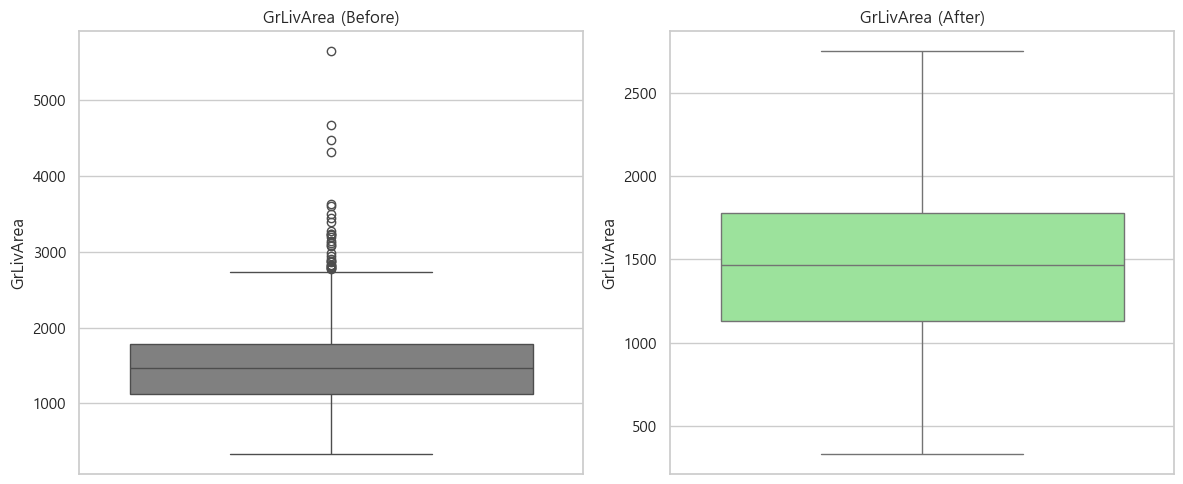

In [136]:
# (2) 원본 데이터(df)와 클리핑(clip) 데이터 Boxplot 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 원본 데이터(df) Boxplot
sns.boxplot(y=df['GrLivArea'], ax=axes[0], color='grey')
axes[0].set_title('GrLivArea (Before)')

# 클리핑(clip) 후 Boxplot
sns.boxplot(y=df_clip['GrLivArea'], ax=axes[1], color='lightgreen')
axes[1].set_title('GrLivArea (After)')

plt.tight_layout()
plt.show()

### (3)제거(drop)방식과 비교 시 클리핑(clip) 방식의 장단점

#### 장점
* 원본 데이터 손실이 없어 데이터를 실수로 제거 하더라도 안전합니다.   


#### 단점
* 예측 모델의 왜곡이 발생할 수 있습니다. 🤔

## 문제 8️⃣: 이상치 처리 후 SalePrice 영향
1. 원본 df, df_clean_drop, df_clip 각각에서 SalePrice의 평균과 표준편차를 비교하세요.
2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

In [ ]:
# TODO:
# df, df_clean_drop, df_clip 각각의 SalePrice 평균/표준편차를 출력하고 해석하세요.

In [123]:
# (1)

# 1. 각 데이터프레임의 SalePrice 통계량 계산
price_stats = pd.DataFrame({
    'Original (df)': df['SalePrice'].describe()[['mean', 'std']],
    'Drop (df_clean_drop)': df_clean_drop['SalePrice'].describe()[['mean', 'std']],
    'Clip (df_clip)': df_clip['SalePrice'].describe()[['mean', 'std']]
})

print("="*15, "[ SalePrice 평균과 표준편차 비교 ]", "="*15)
print(price_stats)

=============== [ SalePrice 평균과 표준편차 비교 ] ===============
      Original (df)  Drop (df_clean_drop)  Clip (df_clip)
mean  180921.195890         176714.088174   180921.195890
std    79442.502883          71254.169818    79442.502883


### (2)극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는가?
* 제거(drop)방식으로 이상값을 다룰 경우, 평균(mean)은 낮아지고, 표준편차(std)가 줄어듭니다.
* 클리핑(clip)방식으로 이상값을 다룰 경우, 원본 데이터의 값과 평균(mean), 표준편차(std)가 동일하게 유지됩니다.

### (3) '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절한가?
* 중간 가격대의 시세를 정확하게 예측하기 위해서는 'df_clean_drop'을 사용하는 것이 적절하다고 생각합니다.
* 앞서 확인한 평균(mean)값과 표준편차(std)값의 비교에서 보았듯이'drop'을 사용하여 안정적인 평균값을 찾고 편차를 줄여 더 정확한 예측이 가능할 것 같습니다.
* 만약, 이상값과 같이 초고가 주택의 시세 예측을 목표로 한다면 'df_clip'을 사용해도 무방할 것 같습니다.

## 문제 9️⃣: 다변량 관점의 이상치
1. 산점도(GrLivArea vs SalePrice)를 다시 그리되,
   - GrLivArea가 IQR 상한보다 큰데
   - SalePrice는 전체 평균보다 낮은 샘플만 다른 색(예: 빨간색)으로 표시하세요.
2. 이런 집은 어떤 의미일 수 있는지 해석을 적으세요

In [ ]:
# TODO:
# mask_suspicious 조건에 해당하는 점들을 빨간색으로 강조 표시한 산점도를 그리세요.

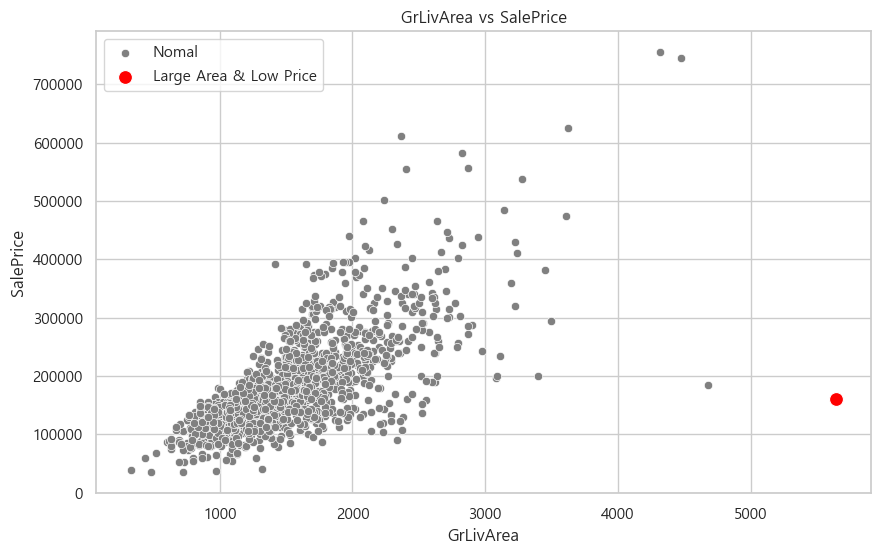

In [140]:
# (1)

# (1-1)SalePrice 평균 구하기
price_mean = df['SalePrice'].mean()

# (1-2)조건에 맞는 샘플 필터링 (GrLivArea가 IQR 상한 보다 크고, SalePrice는 전체 평균보다 낮은 경우)
outliers_02 = df[(df['GrLivArea'] > GrLivArea_upper_bound) & (df['SalePrice'] < price_mean)]

# (1-3)산점도(scatterplot) 그리기
plt.figure(figsize=(10, 6))

# 일반 데이터 설정
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], color='grey', label='Nomal')

# 조건에 부합하는 이상치 설정
sns.scatterplot(x=outliers_02['GrLivArea'], y=outliers_02['SalePrice'], color='red', s=100, label='Large Area & Low Price')

plt.title('GrLivArea vs SalePrice')
plt.legend()
plt.show()

### (2)이런 집은 어떤 의미일 수 있는지 해석을 적으세요.
* 소유주의 개인 사정으로 매물을 급하게 처분하기 위해 판매된 집으로 예상됩니다.   
    *예)     
        * 경매로 넘어가기 직전 급매  
        * 실소유주의 사망으로 인한 매물 처분  
        * 매물 내 형사사건 발생으로 인한 가격 조정  
        * 매물 내 사고 발생으로 인한 가격 조정  

## 문제 🔟: 최종 의사결정 제안서 (서술형)
우리 팀이 만들 모델이 어떤 용도인지에 따라 이상치를 다루는 방식이 달라집니다.

- '일반적인 중간 가격대 주택의 시세 예측' 모델이라면 이상치를 제거하는 게 맞나요, 클리핑이 맞나요, 아니면 그대로 두나요?
- 초고가 주택까지 정확히 예측하는 모델을 만들려면 어떤 접근이 필요할까요?
- 당신의 추천 전략을 간단히 정리하세요.

(1)일반적인 중간 가격대 주택의 시세 예측 모델에서는 데이터의 왜곡을 방지하기 위해 이상치를 제거하는 것이 통계적으로 타당합니다. 다만, 특정 시점의 이상치는 당시 주택 시장의 급격한 변화나 주요 이슈를 대변하는 지표일 수 있습니다. 따라서 이를 단순 노이즈로 간주해 제거하기에 앞서, 시장 변화의 징후나 결과로서 유의미한 데이터인지 별도로 추출하여 심도 있게 분석하는 과정이 선행되어야 한다고 생각합니다.

(2)초고가 주택 시장은 상한선 없이 최고가를 경신하는 특성을 지니므로, 일반적인 통계 기준을 적용하면 이상치가 빈번하게 발생할 수밖에 없습니다. 따라서 일반 주택 모델처럼 이상값을 제거하기보다는, 이를 시장의 핵심 동향으로 보고 유지해야 합니다. 특히 이러한 이상값들만을 별도의 집단으로 구성하여 해당 그룹 내의 평균과 편차를 기반으로 예측하는 차별화된 접근 방식이 필요하다고 생각합니다.